<a href="https://colab.research.google.com/github/Ahmedsayed31/Seq2seq-Eng_to_Ara/blob/main/Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import os
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data_path = '/content/ara_eng.txt'

In [11]:
with open(data_path, 'r') as f:
    text = f.read()
    text=text.split('\n')

In [13]:
for i in range(5):
  print(text[i])

Hi.	مرحبًا.
Run!	اركض!
Help!	النجدة!
Jump!	اقفز!
Stop!	قف!


In [15]:
# splite sentences to Arabic and English
input = []
target = []
for i ,e in enumerate(text[:-1]):
    a,b =e.split('\t')
    input.append(a)
    target.append(b)


In [196]:
df = pd.DataFrame(list(zip(input, target)),columns=['input','target'])

In [197]:
df.head(10)

,input,target
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
5,Go on.,داوم.
6,Go on.,استمر.
7,Hello!,مرحباً.
8,Hurry!,تعجّل!
9,Hurry!,استعجل!


In [128]:
print(df.input.shape)
print(df.target.shape)

(19267,)
(19267,)


In [198]:
# apply lower case for all sentences to reduce the number of words in the dictionary (Vocabulary) and simplify the model.
df['input'] = df['input'].str.lower()

In [199]:
df.input.head()

,input
0,hi.
1,run!
2,help!
3,jump!
4,stop!


In [200]:
# add length columns to remove sentences that less that 2 words
df['length_eng'] = [len(i) for i in df['input'].str.split()]
df['length_ara'] = [len(i) for i in df['target'].str.split()]

In [201]:
df.head()

,input,target,length_eng,length_ara
0,hi.,مرحبًا.,1,1
1,run!,اركض!,1,1
2,help!,النجدة!,1,1
3,jump!,اقفز!,1,1
4,stop!,قف!,1,1


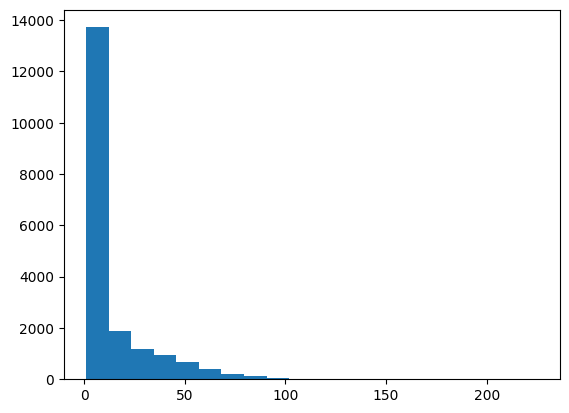

In [202]:
plt.hist(df.length_eng,bins=20)
plt.show()

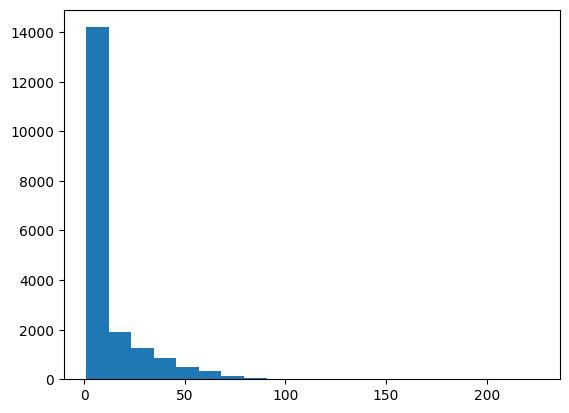

In [203]:
plt.hist(df.length_ara,bins=20)
plt.show()

In [204]:
df[df['length_eng']>3]['input'].shape

(17530,)

In [205]:
df[df['length_ara']>3]['target'].shape

(14685,)

In [206]:
removed_sen = (df['length_ara']<3) & (df['length_eng']<3)
df = df[~removed_sen]
print(df.shape)

(18828, 4)


In [207]:
df = df[(df['length_eng']<75)& (df['length_ara']<75)]


In [208]:
df.shape

(18518, 4)

In [209]:
# Statistics on Data after the filter
print("Average English sentence length:", df['length_eng'].mean())
print("Average Arabic sentence length:", df['length_ara'].mean())
print("Max English sentence length:", df['length_eng'].max())
print("Max Arabic sentence length:", df['length_ara'].max(),"\n")


# Number of unique words (approximate)
eng_unique_words = len(set(' '.join(df['input']).split()))
ar_unique_words = len(set(' '.join(df['target']).split()))
print("Unique English words:", eng_unique_words)
print("Unique Arabic words:", ar_unique_words)

Average English sentence length: 13.81536883032725
Average Arabic sentence length: 11.660276487741656
Max English sentence length: 74
Max Arabic sentence length: 74 

Unique English words: 23331
Unique Arabic words: 43878


In [210]:
# Prepare target sequence for decoder input by adding start and end tokens
df['target'] = df['target'].apply(lambda x:f'<start> {x} <end>')

In [153]:
df.head()

,input,target,length_eng,length_ara
20,I'm 19.,<start> أنا في 19 <end>,2,3
32,Come in.,<start> تعال إلى الداخل <end>,2,3
36,Get out!,<start> اخرج من هنا! <end>,2,3
39,Go away.,<start> اتركني و شأني. <end>,2,3
56,Tom won.,<start> لقد ربح توم. <end>,2,3


In [211]:
English = df.input.values
Arabic = df.target.values

In [212]:
Arabic[:5]

array(['<start> أنا في 19 <end>', '<start> تعال إلى الداخل <end>',
       '<start> اخرج من هنا! <end>', '<start> اتركني و شأني. <end>',
       '<start> لقد ربح توم. <end>'], dtype=object)

## Tokenization

In [213]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [214]:
max_vocab_size = 15000
# Tokenization for English
Eng_tokenizer = Tokenizer(num_words=max_vocab_size,filters='')
Eng_tokenizer.fit_on_texts(English)
eng_seq = Eng_tokenizer.texts_to_sequences(English)

Eng_vocab = Eng_tokenizer.word_index
Eng_vocab_size = min(len(Eng_vocab)+1,max_vocab_size)
max_eng_len=max(len(i) for i in eng_seq)


# Tokenization for Arabic
Ara_tokenizer = Tokenizer(num_words=max_vocab_size,filters='')
Ara_tokenizer.fit_on_texts(Arabic)
ara_seq = Ara_tokenizer.texts_to_sequences(Arabic)

Ara_vocab = Ara_tokenizer.word_index
Ara_vocab_size = min(len(Ara_vocab)+1,max_vocab_size)

max_ara_len=max(len(i) for i in ara_seq)

# padding
pad_eng_seq = pad_sequences(eng_seq,maxlen=max_eng_len,padding='post')
pad_ara_seq = pad_sequences(ara_seq,maxlen=max_ara_len,padding='post')


print("Max English sentence length:", max_eng_len)
print("English Voca size",Eng_vocab_size)

print("Max Arabic sentence length:", max_ara_len)
print("Arabic Voca size",Ara_vocab_size)

Max English sentence length: 74
English Voca size 15000
Max Arabic sentence length: 74
Arabic Voca size 15000


In [215]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, temp_eng, y_train, temp_ara = train_test_split(pad_eng_seq, pad_ara_seq, test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(temp_eng, temp_ara, test_size=0.5, random_state=42)

print("Train size:", len(x_train))
print("Validation size:", len(x_val))
print("Test size:", len(x_test))

Train size: 14814
Validation size: 1852
Test size: 1852


In [216]:
''' This process is crucial for training the decoder to predict
the next word in the target sequence based on the previous words and the encoder's output.
'''
decoder_input_train = np.array([seq[:-1] for seq in y_train])
decoder_input_val = np.array([seq[:-1] for seq in y_val])
decoder_output_train = np.array([seq[1:] for seq in y_train])
decoder_output_val = np.array([seq[1:] for seq in y_val])

decoder_output_train = np.expand_dims(decoder_output_train, -1)
decoder_output_val = np.expand_dims(decoder_output_val, -1)

## LSTM Encoder Decoder

In [160]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

In [223]:
# Encoder
encoder_input_layer = Input(shape=(None,))
encoder_embedding_layer = Embedding(Eng_vocab_size, 256)(encoder_input_layer)

# First LSTM layer
encoder_lstm_1 = LSTM(512, return_sequences=True)(encoder_embedding_layer)
# Second LSTM layer (additional hidden layer)
encoder_lstm_2 = LSTM(256, return_state=True)(encoder_lstm_1)
output_encoder, hidden_state, state_c = encoder_lstm_2
encoder_states = [hidden_state, state_c]

# Decoder
decoder_input_layer = Input(shape=(None,))
decoder_embedding_layer = Embedding(Ara_vocab_size, 256)(decoder_input_layer)

# First LSTM layer in decoder
decoder_lstm_1 = LSTM(512, return_sequences=True)(decoder_embedding_layer, initial_state=encoder_states)
# Second LSTM layer (additional hidden layer)
decoder_lstm_2 = LSTM(256, return_sequences=True)(decoder_lstm_1)
decoder_output_layer = Dense(Ara_vocab_size, activation='softmax')(decoder_lstm_2)

# Define the model
model = Model([encoder_input_layer, decoder_input_layer], decoder_output_layer)
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, None, 256) │  3,840,000 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, None, 512) │  1,574,912 │ embedding_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_27        │ (None, None, 256) │  3,840,000 │ input_layer_27[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ [(None, 256),     │    787,456 │ lstm_41[0][0]     │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ (None, None, 512) │  1,574,912 │ embedding_27[0][… │
│                     │                   │            │ lstm_42[0][1],    │
│                     │                   │            │ lstm_42[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, None, 256) │    787,456 │ lstm_43[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, None,      │  3,855,000 │ lstm_44[0][0]     │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,259,736 (62.03 MB)

 Trainable params: 16,259,736 (62.03 MB)

 Non-trainable params: 0 (0.00 B)

In [224]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [228]:
# Prepared by Earlystopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit([x_train, decoder_input_train], decoder_output_train,
                  batch_size=64,
                  epochs=100,
                  validation_data=([x_val, decoder_input_val], decoder_output_val)
                  ,callbacks=[early_stopping])

Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.8741 - loss: 0.8549 - val_accuracy: 0.8817 - val_loss: 0.9887
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.8726 - loss: 0.8530 - val_accuracy: 0.8818 - val_loss: 0.9931
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.8741 - loss: 0.8302 - val_accuracy: 0.8821 - val_loss: 0.9998
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.8759 - loss: 0.8069 - val_accuracy: 0.8823 - val_loss: 1.0039
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - accuracy: 0.8769 - loss: 0.7913 - val_accuracy: 0.8824 - val_loss: 1.0138
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 42s 153ms/step - accuracy: 0.8796 - loss: 0.7625 - val_accuracy: 0.8828 - val_loss: 1.0191


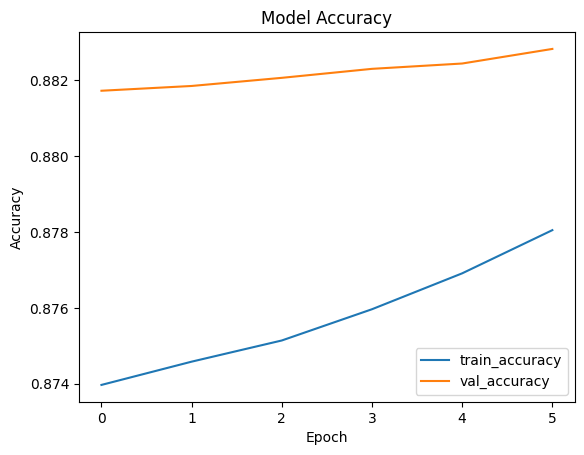

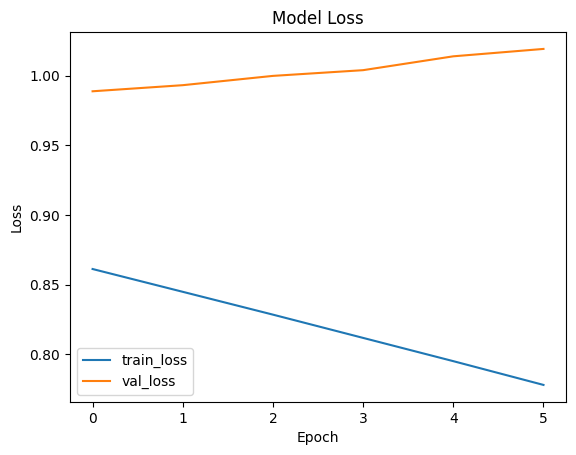

In [229]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [232]:
model.evaluate([x_test, decoder_input_val], decoder_output_val)

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8817 - loss: 0.9924


[1.0272413492202759, 0.8778365254402161]

In [234]:
model.save('/content/drive/MyDrive/Models/Seq2seq_eng_ara_model.h5')